In [1]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install lightgbm

In [3]:
# 2. Load the dataset
df = pd.read_csv("ChildBehaviourAnalysis.csv")
print("Shape:", df.shape)
df.head(5)

Shape: (200, 9)


,Age,Gender,Sleep_Hours,Study_Hours,Play_Hours,Screen_Time,Meals_Per_Day,Mood,Behavior_Category
0,14,Female,8.9,3.0,1.0,0.3,5,Angry,Healthy
1,6,Female,8.8,2.1,1.0,0.3,4,Happy,Healthy
2,11,Female,8.4,3.5,1.3,0.9,3,Happy,Healthy
3,14,Male,8.8,3.5,1.2,0.9,4,Happy,Healthy
4,9,Male,9.3,3.6,1.2,0.6,5,Happy,Healthy


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                200 non-null    int64  
 1   Gender             200 non-null    object 
 2   Sleep_Hours        200 non-null    float64
 3   Study_Hours        200 non-null    float64
 4   Play_Hours         200 non-null    float64
 5   Screen_Time        200 non-null    float64
 6   Meals_Per_Day      200 non-null    int64  
 7   Mood               200 non-null    object 
 8   Behavior_Category  200 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 14.2+ KB


In [5]:
df.isnull().sum()

Age                  0
Gender               0
Sleep_Hours          0
Study_Hours          0
Play_Hours           0
Screen_Time          0
Meals_Per_Day        0
Mood                 0
Behavior_Category    0
dtype: int64

In [6]:
df.columns

Index(['Age', 'Gender', 'Sleep_Hours', 'Study_Hours', 'Play_Hours',
       'Screen_Time', 'Meals_Per_Day', 'Mood', 'Behavior_Category'],
      dtype='object')

In [7]:
numerical_col = [i for i in df.columns if df[i].dtype in ['int64', 'float64']]
print(numerical_col)

['Age', 'Sleep_Hours', 'Study_Hours', 'Play_Hours', 'Screen_Time', 'Meals_Per_Day']


In [8]:
categorical_col = [col for col in df.columns if col not in numerical_col]

print(categorical_col)

['Gender', 'Mood', 'Behavior_Category']


In [9]:
# Encode categorical columns
label_encoders = {}
df_encoded = df.copy()
for col in categorical_col:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [10]:
df_encoded.head(5)

,Age,Gender,Sleep_Hours,Study_Hours,Play_Hours,Screen_Time,Meals_Per_Day,Mood,Behavior_Category
0,14,0,8.9,3.0,1.0,0.3,5,0,0
1,6,0,8.8,2.1,1.0,0.3,4,1,0
2,11,0,8.4,3.5,1.3,0.9,3,1,0
3,14,1,8.8,3.5,1.2,0.9,4,1,0
4,9,1,9.3,3.6,1.2,0.6,5,1,0


In [11]:
label_encoders

{'Gender': LabelEncoder(),
 'Mood': LabelEncoder(),
 'Behavior_Category': LabelEncoder()}

In [12]:
# X= df_encoded.iloc[:,:-1].to_numpy()
# y= df_encoded.iloc[:,-1].to_numpy()

X= df_encoded.iloc[:,:-1]
y= df_encoded.iloc[:,-1]

In [15]:
X

,Age,Gender,Sleep_Hours,Study_Hours,Play_Hours,Screen_Time,Meals_Per_Day,Mood
0,14,0,8.9,3.0,1.0,0.3,5,0
1,6,0,8.8,2.1,1.0,0.3,4,1
2,11,0,8.4,3.5,1.3,0.9,3,1
3,14,1,8.8,3.5,1.2,0.9,4,1
4,9,1,9.3,3.6,1.2,0.6,5,1
...,...,...,...,...,...,...,...,...
195,9,0,6.7,1.1,1.8,1.9,3,0
196,12,1,7.8,2.3,2.7,1.3,3,2
197,9,1,6.8,1.3,2.9,2.0,2,1
198,6,1,7.2,1.1,2.9,1.5,3,0


In [25]:
y

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: Behavior_Category, Length: 200, dtype: int32

In [27]:
# Train-Test Split (BEFORE any resampling/scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize and fit SelectKBest (top 5 features)
kbest = SelectKBest(score_func=f_classif, k=5)
kbest.fit(X_train, y_train)  # X should be your preprocessed features

# 3. Get results (matches your original DataFrame format)
top_5_features = pd.DataFrame({
    "Feature": X_train.columns[kbest.get_support()],  # Selected feature names
    "Importance": kbest.scores_[kbest.get_support()]  # ANOVA F-values
}).sort_values("Importance", ascending=False)

print("✅ Top 5 Features (KBest):")
print(top_5_features)

✅ Top 5 Features (KBest):
         Feature  Importance
3    Screen_Time  497.087785
0    Sleep_Hours  421.830599
2     Play_Hours  223.722302
1    Study_Hours  220.395452
4  Meals_Per_Day  154.891045


In [33]:
# Transform training and test data with KBest
X_train_kbest = kbest.transform(X_train)
X_test_kbest = kbest.transform(X_test)

In [35]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kbest)
X_test_scaled = scaler.transform(X_test_kbest)

In [37]:
# Apply SMOTE (ONLY on the scaled training data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [39]:
y_train.mean()

1.0

In [41]:
y_test.mean()

1.0

In [43]:
colvalues = X.columns

<Axes: >

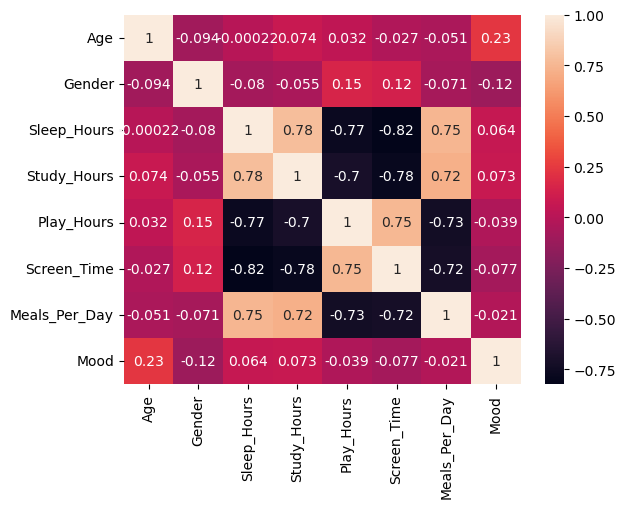

In [45]:
# Assuming X was originally a DataFrame
X_train_df = pd.DataFrame(X_train, columns = colvalues)

# Now compute the correlation matrix
corr_matrix = X_train_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True)

In [46]:
# import pandas as pd

# # Convert X_train to DataFrame with column names if not already
# X_train_df = pd.DataFrame(X_train, columns=['Age', 'Gender', 'Sleep_Hours', 'Study_Hours', 'Play_Hours', 'Screen_Time', 'Meals_Per_Day'])

# # Compute correlation matrix
# corr_matrix = X_train_df.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Find features with correlation > 0.75
# to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# print("Columns to drop due to high correlation:", to_drop)

# # Drop those features from the original dataset
# X_train_reduced = X_train_df.drop(columns=to_drop)

In [49]:
models = {
     "DecisionTree": (DecisionTreeClassifier(),{         
         'criterion': ['gini', 'entropy','log_loss'],
         'splitter':['best', 'random'],
         'max_depth': [5, 10, 20]
    }),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10]
    }),
    
    "RandomForest": (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    }),
    "SVM": (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    })
    # "LightGBM": (LGBMClassifier(), {
    #     'n_estimators': [50, 100],
    #     'learning_rate': [0.01, 0.1],
    #     'num_leaves': [31, 50]
    # })
}

In [51]:
best_model = None
best_score = 0
best_name = ""
best_grid = None

for name, (model, params) in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='f1_weighted', n_jobs=-1,refit=True) #n_jobs = number of processes you wish to run in parallel for this task if it -1 it will use all available processors.
    grid.fit(X_train_resampled, y_train_resampled)
    y_pred = grid.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Best Params: {grid.best_params_}")
    print(f"Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    if f1 > best_score:
        best_model = grid.best_estimator_
        best_score = f1
        best_name = name
        best_grid = grid

Tuning DecisionTree...
Best Params: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
Accuracy: 1.00, F1 Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00         8

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Tuning LogisticRegression...
Best Params: {'C': 0.01}
Accuracy: 1.00, F1 Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00         8

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Tuning RandomForest...
Bes

In [52]:
# Save best model
print(f"\nBest Model: {best_name} with F1 Score: {best_score:.2f}")
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

print("Saved: best_model.pkl, scaler.pkl, label_encoders.pkl")



Best Model: DecisionTree with F1 Score: 1.00
Saved: best_model.pkl, scaler.pkl, label_encoders.pkl


In [53]:
feature_variance = df_encoded.var().sort_values(ascending=False)
print(feature_variance)

Age                  6.650352
Sleep_Hours          2.037446
Screen_Time          1.342309
Meals_Per_Day        0.891231
Study_Hours          0.772840
Play_Hours           0.669805
Mood                 0.651156
Behavior_Category    0.402010
Gender               0.251156
dtype: float64


In [54]:
# # Reconstruct original column names if lost
# original_X = df_encoded.drop("Behavior_Category", axis=1)

# # Get feature importances
# if hasattr(best_model, "feature_importances_"):
#     importances = best_model.feature_importances_
# elif hasattr(best_model, "coef_"):
#     importances = best_model.coef_[0]
# else:
#     importances = [0]*original_X.shape[1]

# # Create DataFrame to view feature importance
# import pandas as pd
# feature_importance_df = pd.DataFrame({
#     "Feature": original_X.columns,
#     "Importance": importances
# }).sort_values(by="Importance", ascending=False)

# top_5_features = feature_importance_df.head(5)
# print("✅ Top 5 Features to use in your Django UI:")
# print(top_5_features)


In [55]:
# Create DataFrame with selected features
selected_features = X_train.columns[kbest.get_support()] 
original_X = pd.DataFrame(X_train_kbest, columns=selected_features)

# Get importances from the trained model
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    importances = best_model.coef_[0]
else:
    importances = [0] * original_X.shape[1]

# Safety check
if len(importances) != len(selected_features):
    raise ValueError(f"Mismatch! Features: {len(selected_features)}, Importances: {len(importances)}")

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show top 5
top_5_features = feature_importance_df.head(5)
print("✅ Top 5 features by model importance:")
print(top_5_features)

✅ Top 5 features by model importance:
         Feature  Importance
3    Screen_Time    0.467758
2     Play_Hours    0.433384
0    Sleep_Hours    0.098858
1    Study_Hours    0.000000
4  Meals_Per_Day    0.000000


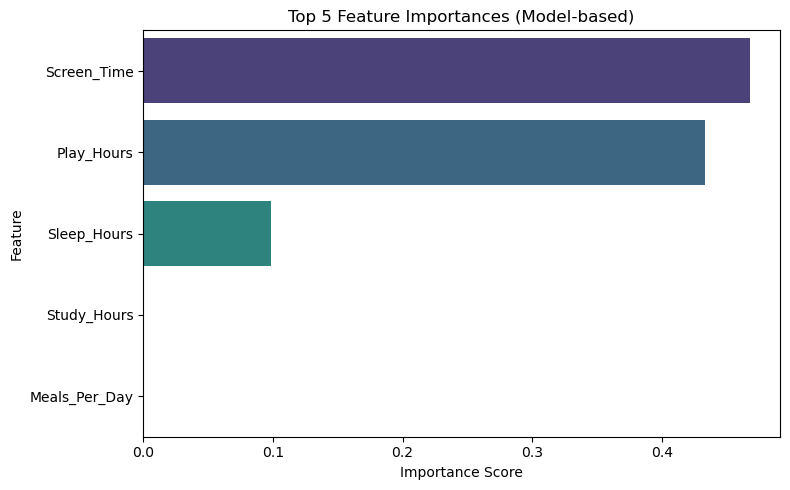

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=top_5_features, palette="viridis")
plt.title("Top 5 Feature Importances (Model-based)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()